In [1]:
pip install fastai2

     |████████████████████████████████| 176 kB 962 kB/s eta 0:00:01
     |████████████████████████████████| 387 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.0 MB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 97.4 MB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 182 kB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 15.6 MB/s eta 0:00:01
  Created wheel for wasabi: filename=wasabi-0.7.1-py3-none-any.whl size=20834 sha256=7915d005e28cd28fbbfbc0a7746c8e8c8d7a2c5787f1deba8f98cc311bf4aa84
  Stored in directory: /Users/alejocoy/Library/Caches/pip/wheels/dc/5e/d4/727b6213e9ebec502ff1bf5998f4a83fef87c3aace8a492243
Successfully built wasabi
Note: you may need to restart the kernel to use updated packages.


# Before Start:
## Run this in google Colab and make sure to Slect GPU in running Time

In [4]:
from fastai2.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

## The Data:

In [5]:
df = pd.read_csv('well_header0.csv')
test_df= pd.read_csv('test0.csv')

FileNotFoundError: [Errno 2] File well_header0.csv does not exist: 'well_header0.csv'

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6731 entries, 0 to 6730
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EPAssetsId           6731 non-null   int64  
 1   CurrentStatus        6731 non-null   object 
 2   WellType             6731 non-null   object 
 3   Formation            6731 non-null   object 
 4   Field                6731 non-null   object 
 5   Pool                 6731 non-null   object 
 6   Surf_Township        6731 non-null   int64  
 7   Surf_Meridian        6731 non-null   object 
 8   Surf_Range           6731 non-null   int64  
 9   Surf_Section         6731 non-null   int64  
 10  Surf_Longitude       6731 non-null   float64
 11  Surf_Latitude        6731 non-null   float64
 12  Surf_QuarterUnit     6731 non-null   object 
 13  Surf_Unit            6731 non-null   object 
 14  Surf_Block           6731 non-null   object 
 15  Surf_NTSMapSheet     6731 non-null   o

We required to specify categorical and numerical columns

In [13]:
cat_vars = ['CurrentStatus','WellType','Formation','Field','Pool','Surf_Meridian','Surf_QuarterUnit','Surf_Unit','Surf_Block','Surf_NTSMapSheet',
                 'Surf_Series','Surf_Area','Surf_Sheet','Surf_QuarterSection','LaheeClass','DrillingContractor','WellProfile','PSACAreaCode','PSACAreaName']
num_vars=list(set(list(df.columns))-  set (cat_vars))
num_vats = num_vars.remove('TVD')
dep_var = 'TVD'

Now let's declare our `procs`

In [16]:
procs = [FillMissing, Categorify, Normalize]

So now our `splits` will be every index *after* the 41395'th item

Let's make our `TabularPandas`! Since we have a large `DataFrame`, we can enable `inplace` to `True` and `reduce_memory` to `True` to save on some storage space (**Note**: `reduce_memory` is by default `True`). To use `inplace`, we need to set `chained_assignment` to `None` in `pandas`

In [17]:
splits = RandomSplitter()(range_of(df))

In [18]:
pd.options.mode.chained_assignment=None

In [94]:
test = TabularPandas(test_df, procs, cat_vars, num_vars, dep_var, y_block=RegressionBlock(),
                   splits=None, inplace=True, reduce_memory=True)

In [95]:
to = TabularPandas(df, procs, cat_vars, num_vars, dep_var, y_block=RegressionBlock(),
                   splits=splits, inplace=True, reduce_memory=True)

In [96]:
to.xs

,CurrentStatus,WellType,Formation,Field,Pool,Surf_Meridian,Surf_QuarterUnit,Surf_Unit,Surf_Block,Surf_NTSMapSheet,Surf_Series,Surf_Area,Surf_Sheet,Surf_QuarterSection,LaheeClass,DrillingContractor,WellProfile,PSACAreaCode,PSACAreaName,ProjectedDepth_na,Surf_Latitude,GroundElevation,ProjectedDepth,DrillMetresPerDay,Surf_Township,DaysDrilling,TotalDepth,Surf_Longitude,BH_Range,KBElevation,Surf_Section,Surf_Range,EPAssetsId
740,4,1,1,117,38,4,1,1,1,1,1,1,1,1,2,61,1,2,4,1,1.545559,0.357065,0.083785,-0.090347,1.522200,-0.375586,-0.248210,-1.616566,-1.031827,0.355045,0.965464,-1.033927,0.939234
4525,1,3,4,7,1,1,1,1,1,1,1,1,1,4,2,27,2,7,7,1,-0.779850,-0.594718,-0.849059,1.890739,-0.772415,-0.480257,-0.809110,0.881133,0.829432,-0.597028,-0.268489,0.830094,-1.074253
4771,1,3,4,120,366,1,1,1,1,1,1,1,1,1,2,60,2,7,7,1,-0.828140,-0.436939,-0.831806,0.149115,-0.834432,-0.445367,-0.886392,0.758168,1.361220,-0.440045,0.395947,1.362671,-1.082309
3988,1,3,4,52,121,1,1,1,1,1,1,1,1,3,2,73,2,7,7,1,-0.650450,-0.537012,-0.847580,2.760109,-0.648382,-0.480257,-0.536207,0.692886,1.494167,-0.538886,0.016269,1.495815,-1.066269
1656,4,1,1,78,3,3,1,1,1,1,1,1,1,3,2,34,2,5,1,1,0.067482,1.346831,0.560756,-0.204461,0.095818,-0.305805,0.325368,-0.484287,-1.563616,1.344184,-1.692281,-1.433360,0.932466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421,1,3,4,116,347,1,1,1,1,1,1,1,1,4,2,68,2,7,7,1,-0.970447,-0.550160,-0.849059,-0.092270,-0.958465,-0.410476,-0.644282,0.955860,0.563538,-0.551969,-0.363408,0.563805,-1.076990
3141,1,3,4,82,330,1,1,1,1,1,1,1,1,1,2,65,2,7,7,1,-1.055164,-0.856220,-0.871143,-1.244698,-1.082498,0.426895,-0.963976,1.017055,0.297643,-0.857214,1.155303,0.297516,-1.099286
2500,4,2,3,57,288,4,1,1,1,1,1,1,1,1,2,54,2,2,4,1,1.441574,0.795338,0.997010,-1.274652,1.460184,3.706597,0.896532,-1.500823,-1.430669,0.811459,-1.312603,-1.433360,0.916393
2334,4,1,4,89,37,2,1,1,1,1,1,1,1,1,2,11,2,4,2,1,-0.475835,-0.856220,-0.457170,0.123149,-0.462332,-0.445367,-0.902694,0.519519,-1.563616,-0.854306,-0.932925,-1.566504,0.919568


In [98]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y=test.train.xs,test.train.y

In [108]:
def rf(xs, y, n_estimators=1000, max_samples=5300,
       max_features=1, min_samples_leaf=10, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [109]:
m=rf(xs,y)

In [110]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)


In [111]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(133.262786, 1080.361429)

And now let's build our `dataloaders`!

In [39]:
dls = to.dataloaders(bs=512)

In [40]:
dls.show_batch()

,CurrentStatus,WellType,Formation,Field,Pool,Surf_Meridian,Surf_QuarterUnit,Surf_Unit,Surf_Block,Surf_NTSMapSheet,Surf_Series,Surf_Area,Surf_Sheet,Surf_QuarterSection,LaheeClass,DrillingContractor,WellProfile,PSACAreaCode,PSACAreaName,ProjectedDepth_na,Surf_Latitude,GroundElevation,ProjectedDepth,DrillMetresPerDay,Surf_Township,DaysDrilling,TotalDepth,Surf_Longitude,BH_Range,KBElevation,Surf_Section,Surf_Range,EPAssetsId,TVD
0,Pumping,Crude Oil,Cardium,Willesden Green,Commingled Pool 007,W5,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,SE,Development,Ironhand Drilling Inc.,Directional,AB2,Foothills Front,False,52.408378,956.400028,3555.000110,506.290013,40.000000,7.000000,3544.000046,-114.729299,6.0,960.900018,1.000000,6.0,2.624628e+06,1878.030029
1,Pumping,Crude Oil,Montney,Pouce Coupe South,Commingled Pool 012,W6,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,SW,Development,Ensign Drilling Inc.,Horizontal,AB7,Northwestern Alberta,False,55.753086,791.299993,4819.000074,314.690009,78.000001,16.000000,5035.000072,-119.619444,11.0,796.599959,15.000000,11.0,2.597646e+06,2170.989990
2,Active,Oil Production,Viking,Dodsland,Dodsland Viking,W3,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,SE,Development,Savanna Drilling Corp.,Horizontal,SK2,Southwestern Saskatchewan,False,51.606628,721.700016,746.000154,1134.500013,30.000000,2.000000,2269.000078,-108.591055,19.0,725.999981,34.000001,19.0,1.169145e+06,751.849976
3,Active,Oil Production,Viking,Dodsland,Dodsland Viking,W3,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,NE,Development,Champion Drilling,Horizontal,SK2,Southwestern Saskatchewan,False,51.686370,657.900025,634.000108,1489.000004,31.000000,1.000000,1489.000092,-108.659811,19.0,662.199993,29.000000,19.0,1.152322e+06,646.900024
4,Pumping,Crude Oil,Cardium,Pembina,Cardium,W5,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,SE,Development,Horizon Drilling Inc.,Directional,AB2,Foothills Front,False,53.139099,932.400025,4255.000064,502.630018,48.000000,7.999999,4021.000081,-115.516882,11.0,936.799969,15.000000,11.0,2.616729e+06,1829.859985
5,Pumping,Crude Oil,Cardium,Willesden Green,Commingled Pool 007,W5,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,NW,Development,Trinidad Drilling Ltd.,Horizontal,AB2,Foothills Front,False,52.623958,978.599982,3970.000132,368.600012,42.000000,10.000000,3686.000075,-114.977049,7.0,982.799979,17.000000,7.0,2.581803e+06,1934.520020
6,Pumping,Crude Oil,Viking,Provost,Commingled MFP9515,W4,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,SE,Development,Tempco Drilling Ltd,Horizontal,AB3,Southeastern Alberta,False,51.926872,777.400030,1750.000119,904.500012,34.000000,2.000000,1809.000142,-111.046125,8.0,781.699994,22.000000,8.0,2.587182e+06,877.659973
7,Active,Oil Production,Viking,Viking - Miscellaneous Area 2,Viking,W3,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,NW,Development,Savanna Drilling,Horizontal,SK2,Southwestern Saskatchewan,False,51.182857,688.799988,708.000114,1462.000005,25.000001,1.000000,1462.000122,-108.375090,18.0,692.999977,31.000000,17.0,1.161743e+06,709.799988
8,Active,Oil Production,Viking,Whiteside Viking,Whiteside Viking,W3,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,NW,Development,Lasso Drilling Corporation,Horizontal,SK2,Southwestern Saskatchewan,False,51.588764,700.400030,702.000140,760.500008,30.000000,2.000000,1521.000097,-109.324087,24.0,704.599957,21.000000,24.0,1.169649e+06,706.010010
9,Active,Oil Production,Viking,Avon Hill,Avon Hill Viking,W3,Not Applica

## The Model:


As we're doing regression, we want to dictate what the maximum value to be (and minimum) so we will use a `y_range`

In [41]:
max_y = np.max(df['TVD'])*1.2

In [42]:
max_y

5239.2

And now we can make a `y_range`

In [43]:
y_range = torch.tensor([0, max_y]); y_range

tensor([   0.0000, 5239.2002])

Next comes our `Learner`. We'll walk through each step

In [44]:
learn = tabular_learner(dls, layers=[200,100], ps=[0.001, 0.01],
                       embed_p=0.04, y_range=y_range, metrics=rmse,
                       loss_func=MSELossFlat())

So we have a lot going on right there. `ps` is overall dropout (helps with overfitting), `embed_p` is dropout on the embedding weights, `exp_rmspe` is Root Mean Square Percentage Error

Let's look at our model:

In [45]:
learn.summary()

TabularModel (Input shape: ['512 x 20', '512 x 13'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            512 x 4              24         True      
________________________________________________________________
Embedding            512 x 4              24         True      
________________________________________________________________
Embedding            512 x 4              20         True      
________________________________________________________________
Embedding            512 x 24             3,000      True      
________________________________________________________________
Embedding            512 x 44             16,148     True      
________________________________________________________________
Embedding            512 x 4              20         True      
________________________________________________________________
Embedding            512 x 2              4          True      
_____________________________________________

## Training

Now let's fit!

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0008317637839354575)

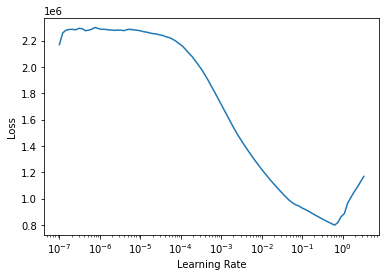

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(10, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,1864029.375000,2133366.750000,1460.604980,00:00
1,1129799.375000,1642970.750000,1281.784058,00:00
2,696357.750000,1114065.500000,1055.493042,00:00
3,475282.468750,923532.187500,961.005737,00:00
4,342361.093750,777573.375000,881.801147,00:00
5,255346.890625,592210.562500,769.552246,00:00
6,195615.203125,360283.156250,600.235962,00:00
7,152806.578125,149532.328125,386.694061,00:00
8,120982.554688,49027.828125,221.422272,00:00
9,97047.554688,19810.519531,140.749847,00:00


/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


## Inference on a test set:
Now that we have a model, we want to make our final competitions that would be submitted to a competition, as such, we can only make the predictions and submit them as a CSV.

We'll practice bringing in an exported model just to show that you do not need the original data. 

In [48]:
learn.export('myModel')

In [49]:
del learn

In [50]:
learn = load_learner('myModel')

Now we generate our `test_dl` from our `test_df`

In [112]:
dl = learn.dls.test_dl(test_df)

We need to tell the `Learner` to return the predictions for the test set we added

In [113]:
raw_test_preds = learn.get_preds(dl=dl)

Let's take a peek

In [114]:
raw_test_preds

(tensor([[1993.8718],
         [2085.9751],
         [2775.5669],
         ...,
         [ 986.2465],
         [ 935.2872],
         [ 959.6848]]), tensor([[1811.0675],
         [1473.5994],
         [1684.7778],
         ...,
         [ 940.5924],
         [1956.5669],
         [ 358.6233]]))

You'll notice `[0]` contains our predictions, and `[1]` contains any labels (if we had any). This is nice because if we accidently run `learn.validate()` on a non-labeled test set, we get the following:

In [115]:
learn.validate(dl=dl)

(#2) [1431468.0,1196.439697265625]

Still runs, just there are no labels so it's `None`

Now back to our predictions! We need to undo our `log` transform first:

In [116]:
test_preds = raw_test_preds[0].numpy().T[0]

(If you want to learn about what `T` does, compare below):

In [117]:
raw_test_preds[0].numpy()

array([[1993.8718 ],
       [2085.975  ],
       [2775.567  ],
       ...,
       [ 986.24646],
       [ 935.28723],
       [ 959.68475]], dtype=float32)

In [118]:
test_preds

array([1993.8718 , 2085.975  , 2775.567  , ...,  986.24646,  935.28723,
        959.68475], dtype=float32)

Now we can submit to Kaggle!

In [119]:
r_mse(raw_test_preds[0].numpy(),raw_test_preds[1].numpy() )

1196.439718

In [66]:
test_df['TVD'] = test_preds
test_df[['EPAssetsId', "TVD"]] = test_df[['EPAssetsId', 'TVD']].astype('int')

And finally we make our submission. **NOTE:** remove the index when generating your submission always!

In [67]:
test_df[['EPAssetsId', 'TVD']].to_csv('submission2.csv', index=False)

# Permutation Importance

Permutation importance is a technique in which we shuffle each column in a dataframe and analyze how changing a particular column affected our `y` values. The more that it was affected, the more "important" we can (generally) call a variable in our neural network. Let's build a quick algorithm to do this:

In [68]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

And now we can simply call `PermutationImportance` to run it!

Getting base error


Calculating Permutation Importance


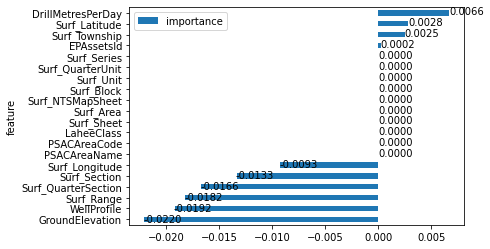

In [69]:
res = PermutationImportance(learn, df.iloc[:1000], bs=64)

In [70]:
res.importance

{'BH_Range': -0.03418498368244247,
 'CurrentStatus': -0.026185866584901015,
 'DaysDrilling': -0.1931666681416413,
 'DrillMetresPerDay': 0.00662624542085451,
 'DrillingContractor': -0.27130249456385086,
 'EPAssetsId': 0.0002167692121084658,
 'Field': -1.1073534426168063,
 'Formation': -0.3239508635629383,
 'GroundElevation': -0.022021648809929736,
 'KBElevation': -0.07938604962057579,
 'LaheeClass': 0.0,
 'PSACAreaCode': 0.0,
 'PSACAreaName': 0.0,
 'Pool': -2.210564011209113,
 'ProjectedDepth': -0.04740884266376253,
 'Surf_Area': 0.0,
 'Surf_Block': 0.0,
 'Surf_Latitude': 0.002774999908898626,
 'Surf_Longitude': -0.009283802644230394,
 'Surf_Meridian': -0.07193728893763825,
 'Surf_NTSMapSheet': 0.0,
 'Surf_QuarterSection': -0.016649999453391757,
 'Surf_QuarterUnit': 0.0,
 'Surf_Range': -0.018175817322483766,
 'Surf_Section': -0.01332870364827165,
 'Surf_Series': 0.0,
 'Surf_Sheet': 0.0,
 'Surf_Township': 0.0024770203291414553,
 'Surf_Unit': 0.0,
 'TotalDepth': -0.1014933857799605,
 'Wel